# Effect of Demographics and Population Clusters on Lock-down Outcomes
### Accompanying paper available at https://arxiv.org/abs/2005.11257

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from skopt import gp_minimize as gpm
import numpy as np
import time
from utils import (Population, Demographics)
from matplotlib import pyplot as plt
import pylab as plb

**Getting started**: we load the generic population file, replace the demographics (RST and SUS values) based on distributions aligned to Indian statistics, reorganize portion of the population into urban clusters, and set the simulations to run for 500 time steps.

**Notation**: We use I0, P0, L0 to denote respectively, the initiation point, period and the level of the lockdown that ESOP is trying to optimize. These are referred ensemble as IPL. In this experiment, all three parameters are being optimized under constraints that I0 must be no less than 12 (i.e. no lock-down before t = 12) and P0 must be no larger than 40 (i.e. no lock-down longer than 40 days)

In [3]:
pop = Population.fileInit( "pop_generic" )
N = pop.N

# Load the patch file
demo = Demographics.fileInit( "patch_India_fit" )

# Use city clusters as initial locations of the individuals
pop.X = demo.loc[:, 0]
pop.Y = demo.loc[:, 1]

# Use RST and SUS values derived from Indian demographics (see accompaying paper)
newSUS = np.sum( demo.demoData[:,1:], axis = 1 ) * 0.2 + 0.1
newRST = 1 - newSUS
pop.SUS = newSUS
pop.RST = newRST

pop.reset()
T = 500

**Age structure in Indian population**: The following code is meant to reproduce Fig 6(a) in the accompanying paper.

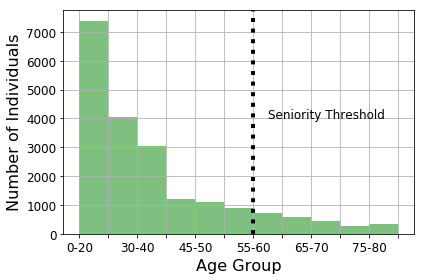

In [4]:
plt.figure()
plt.grid()
plt.hist( demo.demoData[:,0], 11, alpha = 0.5, color = 'g' )
bars = ( "0-20", "", "30-40", "", "45-50", "", "55-60", "", "65-70", "", "75-80", "" )
plt.xlabel( "Age Group", size = 16 )
plt.ylabel( "Number of Individuals", size = 16 )
y_pos = np.arange( len( bars ) )
plt.xticks( y_pos, bars )
plt.axvline( x = 6, linestyle = ":", linewidth = 4, color = 'k' )
plt.text( 6.5, 4000, "Seniority Threshold", fontsize = 12 )
ax = plt.gca()
# ax.set_xlim( -0.5, 11 )
ax.tick_params( axis='both', which='major', labelsize = 12 )
plt.tight_layout()

**Distribution of RST values in population**: The following code is meant to reproduce Fig 6(b) in the accompanying paper.

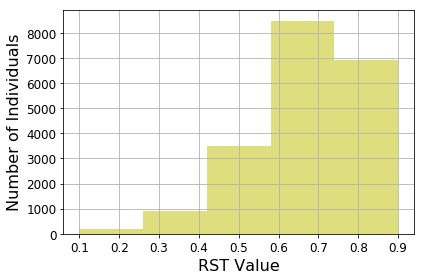

In [5]:
plt.figure()
plt.grid()
plt.hist( 1 - newSUS, 5, alpha = 0.5, color = 'y' )
plt.xlabel( "RST Value", size = 16 )
plt.ylabel( "Number of Individuals", size = 16 )
ax = plt.gca()
ax.tick_params( axis='both', which='major', labelsize = 12 )
plt.tight_layout()

In [6]:
SIDX_S = 0    # Number of susceptible but non-recovered individuals
SIDX_E = 1    # Number of exposed individuals
SIDX_I = 2    # Number of infectious individuals
SIDX_Q = 3    # Number of quanrantined individuals
SIDX_R = 4    # Number of recovered individuals
SIDX_X = 5    # Number of expired individuals
SIDX_V = 6    # Average virulence of the viral strains in E and I populations
SIDX_EI = 7    # Number of infected individuals
SIDX_D = 8    # Number of individuals infected each day

In [7]:
# From the normalized parameters being optimized by ESOP, recover the I0, P0, L0 values
def getIPL0( x ):
    global IPL0c, IPL0w, offset, ul, ll
    IPLVal = np.floor( IPL0c + (np.array(x) - 0.5) / 0.5 * IPL0w ).astype(int) + offset.astype(int)
    # Make sure that the recovered values are legal
    correctedIPLVal = np.minimum( np.maximum( IPLVal, ll ), ul )
    return correctedIPLVal

# Get a lockdown schedule corresponding to a certain IPL value
# The IPL parameter stores lockdown levels from 0 to 10 instead of 0 to 5
# Thus, before using them, divide by 2
def getLKP( IPL ):
    I0 = IPL[0]
    P0 = IPL[1]
    L0 = IPL[2] / 2
    LKP = np.zeros((T,))
    LKP[I0:I0+P0] = L0
    return LKP

# Find out the objective value corresponding to the stats sent as input
def obj( stats, IPL ):
    global SIDX_EI
    fEpi = np.max( stats[ SIDX_EI, : ] )
    # One day of lockdown at level l causes (l/50)% of population to lose their jobs
    daysLockdown = IPL[1]
    # Remember, the IPL stores levels from 0 to 10 instead of 0 to 5
    level = IPL[2] / 2
    fEco = level / 5 * daysLockdown * N / 1000
    return [fEpi, fEco, fEpi + fEco]

# Ask the VIPER simulator what does it think will happen if lock-down is
# initiated as specified in the normalized parameter x
def askSimulator( x ):
    global IPL0c, IPL0w, evalCount, globalDict, freshMask
    # Before starting a simulation, turn back time to reset everything
    pop.reset()
    # Also seed the RNG so that simulations are replicatable
    np.random.seed(0)
    IPL = getIPL0( x )
    # Avoid simulating again for previously queried points
    if tuple(IPL) in globalDict:
        freshMask.append( False )
        return globalDict[tuple(IPL)][-1]
    LKP = getLKP( IPL )
    stats = pop.simulate( T = T, LKP = LKP, minimal = True )
    globalDict[tuple(IPL)] = obj( stats, IPL )
    freshMask.append( True )
    evalCount += 1
    return obj( stats, IPL )[-1]

# Once ESOP is done, find out which parameter, i.e. which values of I0, P0, L0 won!
def getWinner():
    global globalDict
    keys = list( globalDict.keys() )
    vals = np.array( list( globalDict.values() ) )[:,-1]
    winnerIdx = np.argmin( vals )
    winner = np.array( keys[ winnerIdx ] )
    return winner

**Multi-scale Optimization**: ESOP performs Bayesian optimization in a multi-scale manner in several epochs. Initial epochs perform coarse optimization to roughly identify the region with promising objective values. Later epochs zoom into those regions to more and more finely search to obtain points offering highly optimal objective values.

In multi-dimensional optimization cases such as this, where 3 parameters are simultaneously getting optimized, this procedure is made slightly more robust by retaining a diverse _active set_ of good-performing candidates from each epoch and searching around them in the next epoch.

In [8]:
def getAllPairsDistances( A, B ):
    weights = np.array( [ 0.01, 0.01, 0.1 ] )
    Aw = weights * A
    Bw = weights * B
    squaredNormsA = np.square( np.linalg.norm( Aw, axis = 1 ) )
    squaredNormsB = np.square( np.linalg.norm( Bw, axis = 1 ) )
    dists = squaredNormsA[:, np.newaxis] + squaredNormsB - 2 * Aw.dot( Bw.T )
    dists[ dists < 0 ] = 0
    return dists

def addCandidates( res ):
    global branchBound, candidates
    perm = np.argsort( res.func_vals )
    for i in range( 2 * branchBound ):
        key = tuple( getIPL0( res.x_iters[ perm[i] ] ) )
        val = res.func_vals[ perm[i] ]
        if key not in candidates:
            candidates[key] = val

def updateActive():
    global branchBound, candidates
    keys = list( candidates.keys() )
    vals = list( candidates.values() )
    perm = np.argsort( vals )
    # Screen the top few best performing keys
    n = min( 2 * branchBound, len( candidates ) )
    keysScreened = np.array( [ keys[ perm[j] ] for j in range(n) ] )
    activeSet = np.zeros( (branchBound, keysScreened.shape[1]) )
    # Definitely include the best performing candidate in the active set
    i = 0
    activeSet[0,:] = keysScreened[i,:]
    # To select the rest of the active set, perform the k-means++ algorithm
    for t in range( 1 , min( branchBound, len( candidates ) ) ):
        dist = np.min( getAllPairsDistances( keysScreened, activeSet[0:t,:] ), axis = 1 )
        probs = dist/np.sum(dist)
        i = np.argmax( probs ) # Alternatively, we could have used np.random.choice( np.arange(n), p = probs )
        activeSet[t,:] = keysScreened[i,:]
    return activeSet

In [9]:
# All parameters are optimized in various ranges that are described using
# the center point of the range, the half-width of the range and the initial
# offset of the range e.g. the range with center c, width w and offset o is
# the range [o + c - w, o + c + w]. Each of the three parameters I0, P0, L0
# have their own centers, widths and offsets specified below
IPL0c = np.array( [25, 20, 5] )
IPL0w = np.array( [25, 20, 5] )
offset = np.array( [12, 0, 0] )

# Upper and lower bounds on legal values of lock-down initiation points
ul = np.array( [62, 40, 10] )
ll = np.array( [12, 0, 0] )

branchBound = 2
activeSet = []
evalCount = 0
globalDict = {}
freshMask = []

candidates = {}
res = gpm( askSimulator, [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],  acq_func = "EI", n_calls = 20, n_random_starts = 5, random_state = 0 )
addCandidates( res )
activeSet = updateActive()
# Halve the width of the region in which we are searching
IPL0w = IPL0w / 2

for epoch in range(5):
    print( "epoch = ", epoch )
    candidates = {}
    for subepoch in range( len( activeSet ) ):
        print( "subepoch %d of %d" % ( subepoch + 1, len( activeSet ) ) )
        IPL0c = activeSet[subepoch]
        res = gpm( askSimulator, [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],  acq_func = "EI", n_calls = 20 - epoch, n_random_starts = 5, random_state = 0 )
        addCandidates( res )
    # Refine the search in the next epoch
    # Choose new candidates to populate the active set
    activeSet = updateActive()
    # Halve the width of the region in which we are searching
    IPL0w = IPL0w / 2

epoch =  0
subepoch 1 of 2
subepoch 2 of 2
epoch =  1
subepoch 1 of 2
subepoch 2 of 2
epoch =  2
subepoch 1 of 2
subepoch 2 of 2
epoch =  3
subepoch 1 of 2


subepoch 2 of 2


epoch =  4
subepoch 1 of 2
subepoch 2 of 2


**Convergence Plot**: The following plot shows how fast ESOP converges to a near-optimal point

Start on day 27, last for 40 days, at level 3.000000


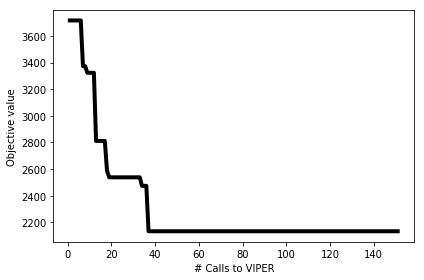

In [10]:
# Find out the suggestion made by ESOP
IPLBest = getWinner()
print( "Start on day %d, last for %d days, at level %f" % ( IPLBest[0], IPLBest[1], IPLBest[2]/2 ) )

validVals = np.array( list( globalDict.values() ) )
mins = np.minimum.accumulate( validVals[:,2] )
plt.figure()
plt.plot( np.arange(1, len( validVals ) + 1), mins, color = 'k', linewidth = 4 )
plt.xlabel( "# Calls to VIPER" )
plt.ylabel( "Objective value" )
plt.tight_layout()

# Final Results

In [11]:
# Get hold of outcomes had no lock-down been applied at all
pop.reset()
np.random.seed(0)

LKP = np.zeros((T,))
(statsNoLockDown, tInfect, tQuarantine, tRecovery, tExpiry) = pop.simulate( T = T, LKP = LKP )

# Now get hold of outcomes with the lock-down suggested by ESOP
pop.reset()
np.random.seed(0)

LKP = getLKP( IPLBest )

(stats, tInfect, tQuarantine, tRecovery, tExpiry) = pop.simulate( T = T, LKP = LKP )

outcome = obj( stats, IPLBest )
print( "%d Infected" % len(tInfect) )
print( "%d Expired" % len(tExpiry) )
print( "Peak %d" % max(stats[SIDX_EI,:]) )
print( "Recovery time %f" % np.mean( tRecovery ) )
print( "Expiry time %f" % np.mean( tExpiry ) )
print( "Quarantine time %f" % np.mean( tQuarantine ) )
print( "%d Quarantined" % len( tQuarantine ) )
print( "Objective acheived is %f (fEpi) + %f (fEco) = %f (overall)" % (outcome[0], outcome[1], outcome[2]) )

10849 Infected
0 Expired
Peak 1653
Recovery time 17.019725
Expiry time nan
Quarantine time 12.008547
117 Quarantined
Objective acheived is 1653.000000 (fEpi) + 480.000000 (fEco) = 2133.000000 (overall)


**Outcome of Lock-down suggested by ESOP**: The following code is meant to reproduce Fig 7(b) in the accompanying paper.

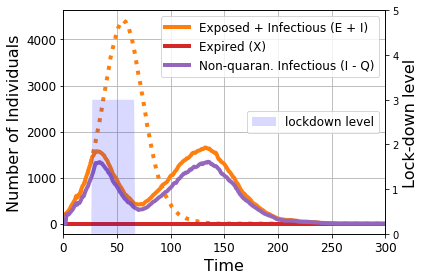

In [12]:
names = [ "S", "E", "I", "Q", "R", "X", "V", "EI", "D" ]
fullnames = [ "Susceptible (S)", "Exposed (E)", "Infectious (I)", "Quarantined (Q)", "Recovered (R)", "Expired (X)", "V", "Exposed + Infectious (E + I)", "Daily" ]

fig = plt.figure()
plt.plot( statsNoLockDown[SIDX_EI,:], color = "#ff7f0e", linestyle = ":", linewidth = 4 )
plt.plot( stats[SIDX_EI,:], label = fullnames[SIDX_EI], color = "#ff7f0e", linewidth = 4 )
plt.plot( stats[SIDX_X,:], label = fullnames[SIDX_X], color = "#d62728", linewidth = 4 )
plt.plot( stats[SIDX_I,:] - stats[SIDX_Q], label = "Non-quaran. Infectious (I - Q)", color = "#9467bd", linewidth = 4 )
ax = plt.gca()
plt.grid()
plt.xlabel("Time", size = 16)
plt.ylabel("Number of Individuals", size = 16)
ax.tick_params( axis='both', which='major', labelsize = 12 )
ax.set_xlim( 0, 300 )
plt.legend( loc = "upper right", fontsize = 12 )
ax2 = ax.twinx()
fillLimit = LKP
fillLimit[0] = fillLimit[-1] = 0
plb.fill( np.arange( T ), fillLimit, facecolor = "blue", label = "lockdown level", alpha = 0.15 )
ax2.set_ylim([0,5])
plt.ylabel( "Lock-down level", size = 16 )
plt.legend( loc = "center right", fontsize = 12 )
plt.tight_layout()